# Quasi-continuous BN

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

aGrUM cannot (currently) deal with with continuous variables. However, a discrete variable with a large enough domain size is an approximation of such variables.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

#nbr of states for quasi continuous variables. You can change the value 
#but be careful of the quadratic behavior of both memory and time complexity
#in this example.
minB,maxB=-3,3
minC,maxC=4,14
NB=200 

BN{nodes: 2, arcs: 1, domainSize: 400, dim: 399, mem: 3Ko 144o}


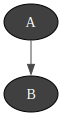

In [2]:
bn=gum.BayesNet("Quasi-Continuous")
bn.add(gum.LabelizedVariable("A","A binary variable",2))
bn.add(gum.NumericalDiscreteVariable("B","A range variable",minB,maxB,NB))
bn.addArc("A","B")
print(bn)
bn=gum.fastBN(f"A[3]->B[{minB}:{maxB}:{NB}]")
gnb.showBN(bn)

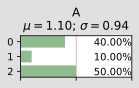

In [3]:
bn.cpt("A")[:]=[0.4, 0.1,0.5]
gnb.showProba(bn.cpt("A"))

## CPT for quasi-continuous variables (with parents)

Using python (and scipy), it is easy to find pdf for continuous variable


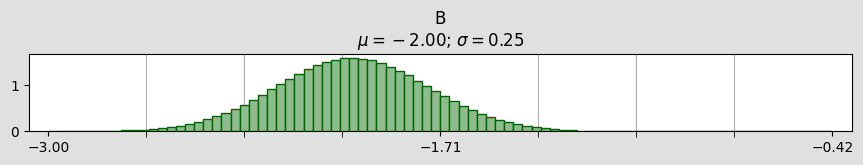
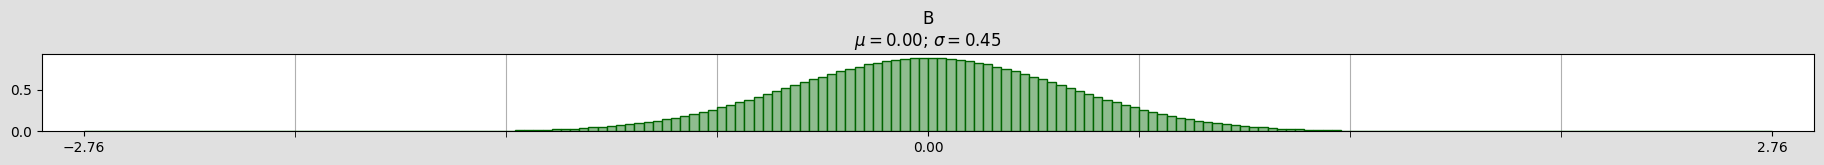
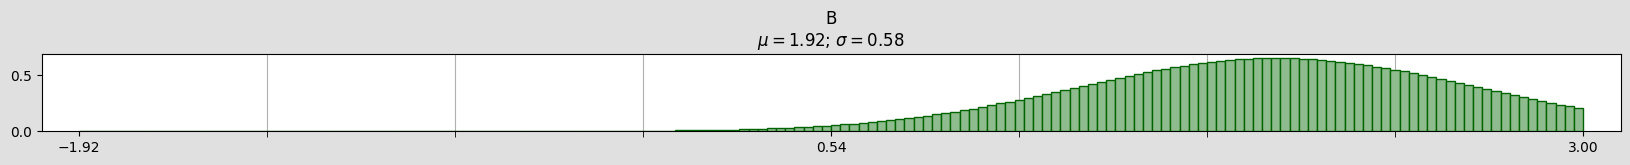

In [4]:
from scipy.stats import norm,genhyperbolic

bn.cpt("B").fillFromDistribution(norm,loc="-2+A*2",scale="(5+A*4)/20")

gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":0})),caption="P(B|A=0)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":1})),caption="P(B|A=1)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":2})),caption="P(B|A=1)")
gnb.flow.display()

## Quasi-continuous inference (with no evidence)

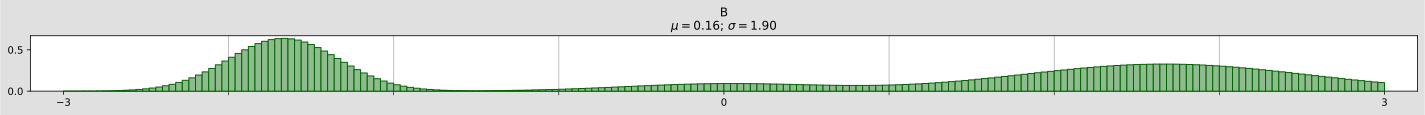

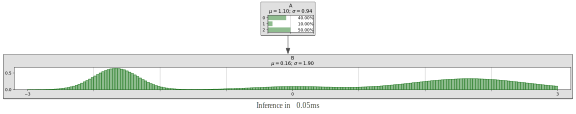

In [5]:
gnb.showPosterior(bn,target="B",evs={})
gnb.showInference(bn)

## Quasi-continuous inference with numerical evidence expressed as logical propositions `evEq` or `evIn` and boolean operators

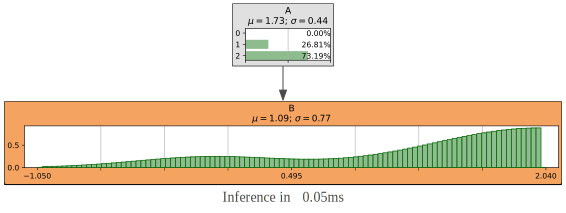

In [6]:
gnb.showInference(bn,evs=[bn.evIn("B",-1,2)]) # we observed B between -1 and 2

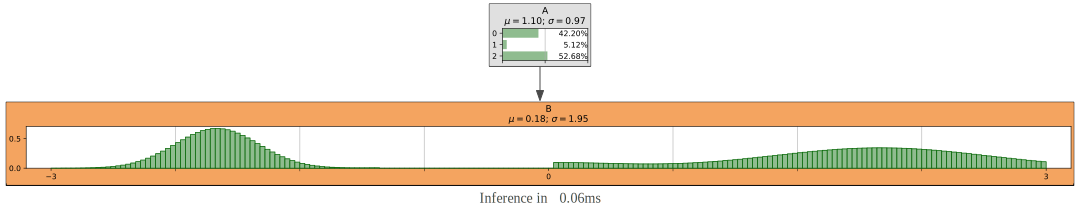

In [7]:
gnb.showInference(bn,evs=[~ bn.evIn("B",-1,0)],size="15!") # we observed B not being between -1 and 0

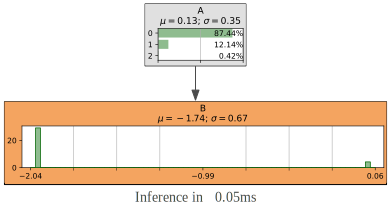

In [8]:
gnb.showInference(bn,evs=[bn.evEq("B",0) | 
                          bn.evEq("B",-2)]) # we observed B being -1 or 2

## Quasi-continuous variable with quasi-continuous parent

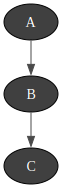

In [9]:
bn.add(f"C[{minB}:{maxB}:{NB}]")
bn.addArc("B","C")
gnb.showBN(bn) # B and C are quasi-continouous

Even if this BN is quite small (and linear), the size of nodes $B$ et $C$ are rather big and creates a complex model (NBxNB parameters in $P(C|B)$).

In [10]:
print("nombre de paramètres du bn : {0}".format(bn.dim()))
print("domaine du bn : 10^{0}".format(bn.log10DomainSize()))

nombre de paramètres du bn : 40399
domaine du bn : 10^5.079181246047625



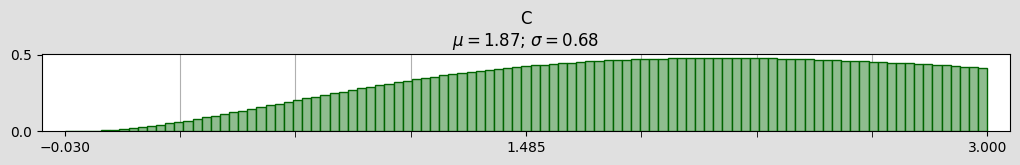
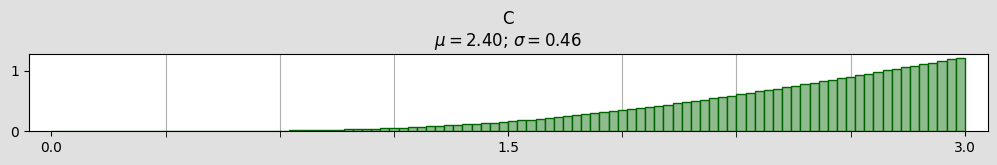
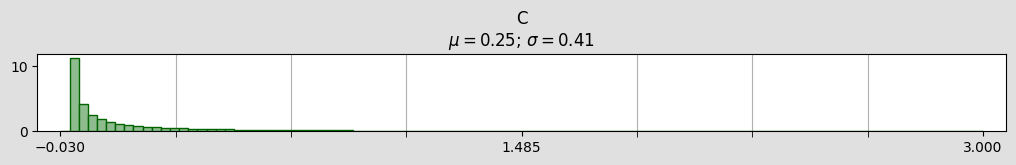

In [11]:
from scipy.stats import gamma

bn.cpt("C").fillFromDistribution(gamma,a="B+3.1",loc=0,scale=1)

def showB(x:float):
    gnb.flow.add(gnb.getProba(bn.cpt("C").extract({"B":f"{x}"})),
                 caption=f"P(C|B={x})")
    
gnb.flow.clear()
showB(0)
showB(3)
showB(-3)
#showB(NB-1)
gnb.flow.display()

### Inference in quasi-continuous BN


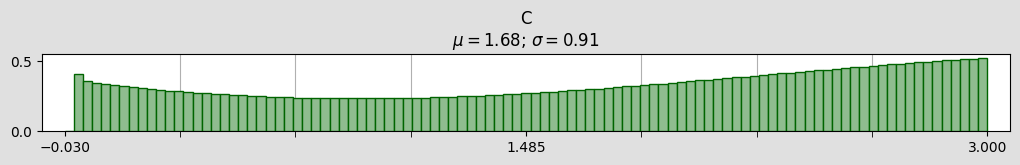

In [12]:
import time

ts = time.time()
ie=gum.LazyPropagation(bn)
ie.makeInference()
q=ie.posterior("C")
te=time.time()
gnb.flow.add(gnb.getPosterior(bn,target="C",evs={}),caption=f"P(C) computed in {te-ts:2.5f} sec for a model with {bn.dim()} paramters")
gnb.flow.display()


## Changing prior


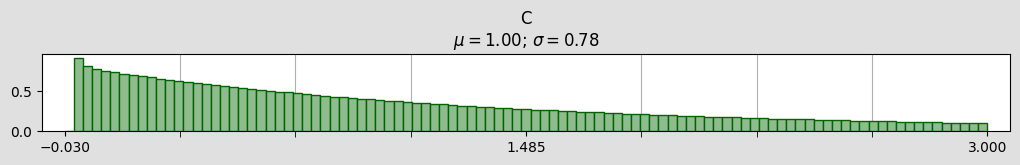

In [13]:
bn.cpt("A")[:]=[0.9,0.1,0.0]
             
gnb.flow.add(gnb.getPosterior(bn,target="C",evs={}),caption="P(C) with P(A)=[0.9,0.1,0.0]")
gnb.flow.display()

## inference with evidence in quasi-continuous BN

We want to compute 
<ul><li>
$P(A | C=3)$ 
</li><li>
$P(B | C=3)$
</li></ul>

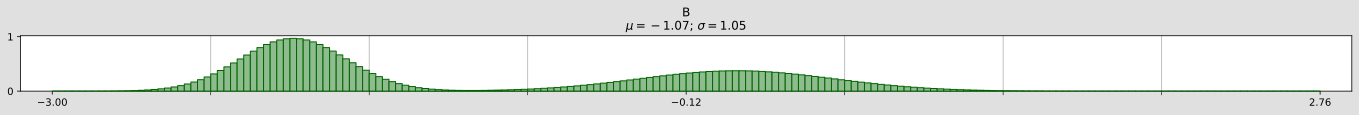

In [14]:
ie=gum.LazyPropagation(bn)
ie.setEvidence([bn.evEq("C",3)])
ie.makeInference()
gnb.showProba(ie.posterior("B"))

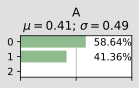

In [15]:
gnb.showProba(ie.posterior("A"))

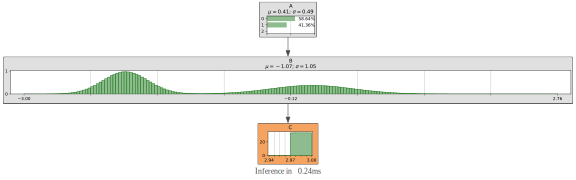

In [16]:
gnb.showInference(bn,evs=[bn.evEq("C",3)])

## Multiple inference : MAP DECISION between Gaussian and generalized hyperbolic distributions

What is the behaviour of $P(A | C=i)$&nbsp;&nbsp; when $i$ varies ? I.e. we perform a MAP decision between the two models ($A=0$&nbsp; for the Gaussian distribution and $A=1$&nbsp; for the generalized hyperbolic  distribution).

In [17]:
bn.cpt("A")[:]=[0.1, 0.7,0.2]
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in range(bn.variable("C").domainSize()):
    print(i)
    ie.setEvidence({'C':i})
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])

x=[float(v) for v in bn.variable("C").labels()]
plot(x,p0)
plot(x,p1)
title("P( A | C=i) with prior p(A)=[0.1,0.9]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()

text(x[inters]-0.2,p0[inters],
     "{0},{1:5.4f}  ".format(x[inters],p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='right');

0


Exception: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)

i.e. if $C<13.2308$ then $A=1$ else $A=0$

### Changing the prior $P(A)$

In [ ]:
bn.cpt("A").fillWith([0.4, 0.6])
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in range(300):
    ie.setEvidence({'C':i})
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])
x=[float(v) for v in bn.variable("C").labels()]
plot(x,p0)
plot(x,p1)
title("P( A | C=i) with prior p(A)=[0.1,0.9]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()

text(x[inters]+0.2,p0[inters],
     "{0},{1:5.4f}  ".format(x[inters],p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='left');

ie. with $p(A)=[0.4,0.6]$, The decision rule is "if $C<7.8462$ then $A=1$ else $A=0$".